
# **Include any disclaimers about the use of AI and cite the parts of the code that AI have been used for.**

In [9]:
import sys
if not sys.version.startswith("3.12"):
    raise RuntimeError("This notebook requires Python 3.12")

#!pip install numpy pandas matplotlib seaborn scikit-learn torch platform psutil getpass

# Hardware and user spercifications

import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle

#CODE HERE (optional): import any module needed from sklearn package

def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)

    # OS and hardware
    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")

    # User
    print(f"PC Username      : {getpass.getuser()}")

    # Python and environment
    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")

    # GPU (if PyTorch is installed)
    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

SYSTEM INFORMATION
Operating System : Linux 6.6.87.2-microsoft-standard-WSL2
Processor        : x86_64
CPU Cores        : 12
RAM              : 7.57 GB
PC Username      : swesan
Python Version   : 3.12.12
Working Dir      : /home/swesan/breast-cancer-prediction-pytorch
GPU Device       : NVIDIA GeForce RTX 3050 6GB Laptop GPU
CUDA Version     : 12.6



Here, we load, split, scale the data. Then we convert them to PyTorch Tensors.

In [10]:
# --- Data Loading and Preprocessing ---

# CODE HERE: Load the dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

# CODE HERE: Split the data (80% train, 20% validation). Set random_state=random_seed.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

# CODE HERE: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# CODE HERE: Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")

Training features shape: torch.Size([455, 30])
Validation features shape: torch.Size([114, 30])


Next, we define the Neural Network (NN).

In [11]:
# --- Model Definition ---

# CODE HERE: define the asked NN here
class BreastCancerNN(nn.Module):
    def __init__(self, input_size):
        super(BreastCancerNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Converts output to probability between 0 and 1
        )

    def forward(self, x):
        return self.network(x)

input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")

Model will accept 30 input features.
--- 3. Model Class Defined ---


Part 1:

In [12]:
def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train() # Set model back to train mode
    return loss.item()

def stochastic_gradient_descent(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                max_iterations, check_every, patience, threshold):

    # CODE HERE: fill function. Use calculate_full_loss function for loss.
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    stop_iteration = max_iterations
    iterations = list(range(0, max_iterations, check_every))
    best_model_state = None
    no_improve_count = 0  # for patience tracking
    
    n_samples = X_train.shape[0]

    for i in range(max_iterations):
        # --- 1. Pick a random sample (SGD style) ---
        idx = torch.randint(0, n_samples, (1,))
        x_sample = X_train[idx]
        y_sample = y_train[idx]

        # --- 2. Forward pass ---
        output = model(x_sample)
        loss = criterion(output, y_sample)

        # --- 3. Backward + Optimize ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- 4. Record and check every 1/10th of epoch ---
        if (i + 1) % check_every == 0:
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Iteration {i+1}/{max_iterations} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            # --- Early stopping logic ---
            if val_loss + threshold < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                no_improve_count = 0
            else:
                no_improve_count += 1

            # Stop training if patience exceeded
            if no_improve_count >= patience:
                stop_iteration = i + 1
                print(f"Early stopping triggered at iteration {stop_iteration}.")
                break

    return train_losses, val_losses, iterations, stop_iteration, best_model_state

Training and plot:

Iteration 500/5000 | Train Loss: 0.2214 | Val Loss: 0.2326
Iteration 1000/5000 | Train Loss: 0.0950 | Val Loss: 0.1073
Iteration 1500/5000 | Train Loss: 0.0650 | Val Loss: 0.0915
Iteration 2000/5000 | Train Loss: 0.0543 | Val Loss: 0.0926
Iteration 2500/5000 | Train Loss: 0.0486 | Val Loss: 0.0759
Iteration 3000/5000 | Train Loss: 0.0433 | Val Loss: 0.0799
Iteration 3500/5000 | Train Loss: 0.0409 | Val Loss: 0.0770
Iteration 4000/5000 | Train Loss: 0.0346 | Val Loss: 0.0804
Early stopping triggered at iteration 4000.
Plotting Part 1 results...


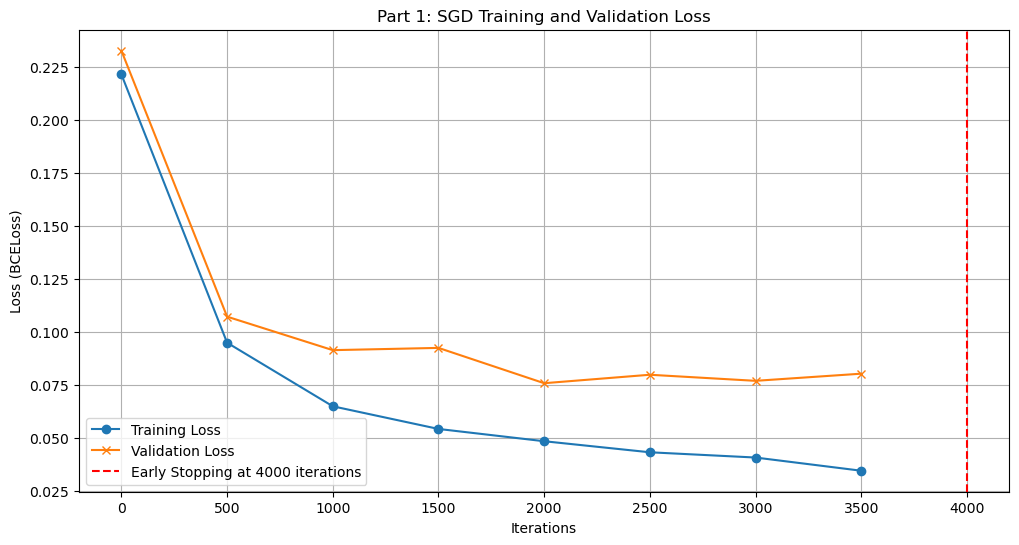


Accuracy of Early-Stopped Model on Validation Set: 95.61%


In [13]:
# --- Hyperparameters for Part 1 ---
LEARNING_RATE = 0.01
MAX_ITERATIONS = 5000
CHECK_EVERY = MAX_ITERATIONS // 10
PATIENCE = 3
THRESHOLD = 1e-4

# --- Model Initialization ---

#CODE HERE
model_sgd = BreastCancerNN(input_features)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# --- Run Training ---

#CODE HERE
train_losses_sgd, val_losses_sgd, iterations_sgd, stop_iter, best_model_state = stochastic_gradient_descent(
    model_sgd, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    MAX_ITERATIONS, CHECK_EVERY, PATIENCE, THRESHOLD
)

# restore the best model weights
model_sgd.load_state_dict(best_model_state)
min_len = min(len(iterations_sgd), len(train_losses_sgd), len(val_losses_sgd))
iterations_sgd = iterations_sgd[:min_len]
train_losses_sgd = train_losses_sgd[:min_len]
val_losses_sgd = val_losses_sgd[:min_len]

# --- Plotting Results ---
print("Plotting Part 1 results...")


plt.figure(figsize=(12, 6))
plt.plot(iterations_sgd, train_losses_sgd, label='Training Loss', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='Validation Loss', marker='x')
plt.axvline(x=stop_iter, color='red', linestyle='--',
            label=f'Early Stopping at {stop_iter} iterations')
plt.title('Part 1: SGD Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Accuracy ---

#CODE HERE

with torch.no_grad():

    #CODE HERE
    preds = model_sgd(X_val_t)
    preds_class = (preds >= 0.5).float()
    accuracy = (preds_class.eq(y_val_t)).sum().item() / y_val_t.size(0)

    print(f"\nAccuracy of Early-Stopped Model on Validation Set: {accuracy * 100:.2f}%")


Part 2:

In [14]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every):

    #CODE HERE: fill function
    n_samples = X_train.shape[0]
    train_losses, val_losses = [], []
    iterations = []

    for i in range(num_iterations):
        # --- 1. Random mini-batch selection ---
        indices = torch.randint(0, n_samples, (batch_size,))
        X_batch = X_train[indices]
        y_batch = y_train[indices]

        # --- 2. Forward pass ---
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # --- 3. Backward + Optimize ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- 4. Record loss every check_every iterations ---
        if (i + 1) % check_every == 0:
            with torch.no_grad():
                model.eval()
                train_loss = criterion(model(X_train), y_train).item()
                val_loss = criterion(model(X_val), y_val).item()
                model.train()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i + 1)

            print(f"Iteration {i+1}/{num_iterations} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses, iterations, model # Return the final model


Training and plot:

Iteration 500/5000 | Train Loss: 0.1891 | Val Loss: 0.2033
Iteration 1000/5000 | Train Loss: 0.0898 | Val Loss: 0.1140
Iteration 1500/5000 | Train Loss: 0.0669 | Val Loss: 0.0988
Iteration 2000/5000 | Train Loss: 0.0561 | Val Loss: 0.0928
Iteration 2500/5000 | Train Loss: 0.0488 | Val Loss: 0.0917
Iteration 3000/5000 | Train Loss: 0.0433 | Val Loss: 0.0875
Iteration 3500/5000 | Train Loss: 0.0388 | Val Loss: 0.0875
Iteration 4000/5000 | Train Loss: 0.0352 | Val Loss: 0.0904
Iteration 4500/5000 | Train Loss: 0.0320 | Val Loss: 0.0889
Iteration 5000/5000 | Train Loss: 0.0292 | Val Loss: 0.0909
Plotting Part 2 comparison...


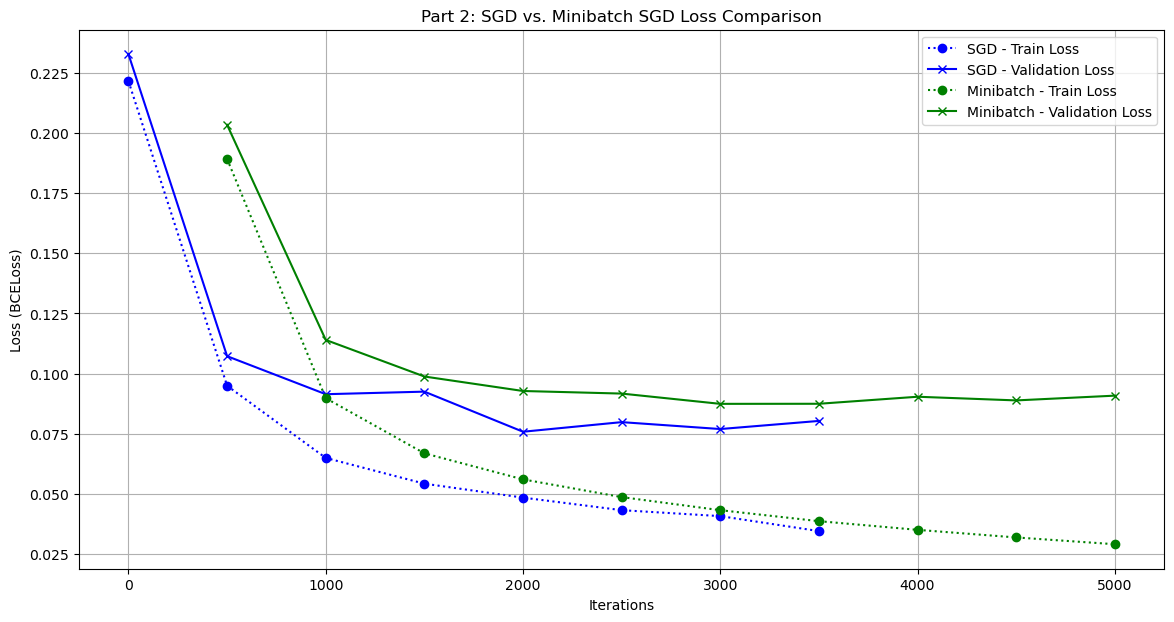

In [15]:
# --- Hyperparameters for Part 2 ---
LEARNING_RATE_MB = 0.01
NUM_ITERATIONS_MB = 5000
BATCH_SIZE = 32
CHECK_EVERY_MB = NUM_ITERATIONS_MB // 10

# --- Model Initialization ---

#CODE HERE
model_mb = BreastCancerNN(input_features)
criterion = nn.BCELoss()
optimizer_mb = optim.SGD(model_mb.parameters(), lr=LEARNING_RATE_MB)

# --- Run Minibatch Training ---

#CODE HERE
train_losses_mb, val_losses_mb, iterations_mb, model_mb = train_with_minibatch(
    model_mb, criterion, optimizer_mb,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_MB, BATCH_SIZE, CHECK_EVERY_MB
)


# --- Plotting Comparison ---
print("Plotting Part 2 comparison...")
plt.figure(figsize=(14, 7))

# SGD (Part 1)
plt.plot(iterations_sgd, train_losses_sgd, label='SGD - Train Loss', linestyle=':', color='blue', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='SGD - Validation Loss', linestyle='-', color='blue', marker='x')

# Minibatch (Part 2)
plt.plot(iterations_mb, train_losses_mb, label='Minibatch - Train Loss', linestyle=':', color='green', marker='o')
plt.plot(iterations_mb, val_losses_mb, label='Minibatch - Validation Loss', linestyle='-', color='green', marker='x')

plt.title('Part 2: SGD vs. Minibatch SGD Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

Performance evaluation:

In [17]:
# --- Performance Metrics Comparison ---

def get_metrics(model, X_val, y_val):
    """Helper function to get accuracy, precision, and recall."""
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_val)
        y_pred = (y_pred_prob > 0.5).int().numpy() # Convert to numpy
        y_true = y_val.numpy()

        acc = accuracy_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
    return acc, pre, rec

# Get metrics for Part 1 (Early-Stopped SGD Model)

#CODE HERE: USING get_metrics function
acc_sgd, pre_sgd, rec_sgd = get_metrics(model_sgd, X_val_t, y_val_t)

# Get metrics for Part 2 (Final Minibatch Model)

#CODE HERE: USING get_metrics function
acc_mb, pre_mb, rec_mb = get_metrics(model_mb, X_val_t, y_val_t)

# --- Show Results in a Table ---
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Part 1: Early-Stopped SGD': [f"{acc_sgd:.4f}", f"{pre_sgd:.4f}", f"{rec_sgd:.4f}"],
    'Part 2: Minibatch SGD': [f"{acc_mb:.4f}", f"{pre_mb:.4f}", f"{rec_mb:.4f}"]
}

results_df = pd.DataFrame(results)
print("\n--- Final Performance Metrics on Validation Set ---")

from IPython.display import display
display(results_df)



--- Final Performance Metrics on Validation Set ---


,Metric,Part 1: Early-Stopped SGD,Part 2: Minibatch SGD
0,Accuracy,0.9561,0.9561
1,Precision,0.9855,0.9855
2,Recall,0.9444,0.9444


# EXPLAIN HERE: Based on your experiments, answer the following questions:

1) How does early stopping affect the training and validation loss curves compared to training for all 5000 iterations?

    Early stopping prevents overfitting by halting training once the validation loss stops improving beyond a small threshold. In the plots, the training loss continues to decrease gradually, but the validation loss plateaus and slightly fluctuates after around 4000 iterations indicating that additional training would mainly reduce training error without improving generalization. By stopping early, the model preserves its best state on the validation set, maintaining low validation loss and avoiding the upward drift that can occur if trained longer.

2) How does minibatch SGD affect the smoothness of loss curves compared to true SGD with batch_size=1?

    Mini-batch SGD produces smoother and more stable loss curves because each update uses the average gradient from a batch of samples rather than a single noisy estimate.True SGD (batch size = 1) fluctuates more between iterations since it depends on one random example per update. In your comparison plot, the green (mini-batch) curves vary less and descend more steadily than the blue (true SGD) curves, demonstrating that mini-batch updates reduce gradient noise and improve convergence stability — while still preserving stochasticity benefits.


***Part 3***

In [18]:
class FeedForwardNetWithDropout(nn.Module):
    """
    TODO: Complete this neural network class to include dropout layers.

    The dropout_rate parameter should control the dropout probability.
    When dropout_rate=0.0, no dropout is applied.
    """
    def __init__(self, input_size, dropout_rate=0.0):
        super(FeedForwardNetWithDropout, self).__init__()

        #CODE HERE: Define the NN architecture
        self.layer1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.layer2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.output_layer = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        TODO: Implement the forward pass.

        Return the final output.
        """
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        out = self.output_layer(x)
        out = self.sigmoid(out)
        return out




In [19]:
def calculate_accuracy(model, X, y):
    """
    TODO: Implement accuracy calculation.


    """
    # CODE HERE: Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # CODE HERE: Get model outputs

        outputs = model(X)
        predictions = (outputs >= 0.5).float()
        correct = (predictions == y).sum().item()
        accuracy = correct / y.size(0)
    return accuracy


In [20]:
def train_with_dropout(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                 num_iterations, batch_size, check_every):
    """
    TODO: Complete this training function to support dropout.
    """
    # CODE HERE: Use need to fill like using miniSGD in part 2

    n_samples = X_train.shape[0]
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    iterations = []

    for i in range(num_iterations):
        # --- 1. Random mini-batch selection ---
        indices = torch.randint(0, n_samples, (batch_size,))
        X_batch = X_train[indices]
        y_batch = y_train[indices]

        # --- 2. Forward pass ---
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # --- 3. Backward + Optimize ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- 4. Record loss and accuracy every check_every iterations ---
        if (i + 1) % check_every == 0:
            model.eval()
            with torch.no_grad():
                train_loss = criterion(model(X_train), y_train).item()
                val_loss = criterion(model(X_val), y_val).item()
                train_acc = calculate_accuracy(model, X_train, y_train)
                val_acc = calculate_accuracy(model, X_val, y_val)

            model.train()  # back to training mode for dropout

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            iterations.append(i + 1)

            print(f"Iteration {i+1}/{num_iterations} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs, iterations


In [23]:
DROPOUT_RATES = [0.1, 0.3, 0.5]
LEARNING_RATE_DROPOUT = 0.01
NUM_ITERATIONS_DROPOUT = 5000
BATCH_SIZE_DROPOUT = 32
CHECK_EVERY_DROPOUT = NUM_ITERATIONS_DROPOUT // 10

dropout_results = {}

for dropout_rate in DROPOUT_RATES:
    print(f"\n--- Training with Dropout Rate = {dropout_rate} ---")

    # CODE HERE: Initialize model with current dropout_rate
    model = FeedForwardNetWithDropout(input_features, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_DROPOUT)


    # Train the model
    train_losses, val_losses, train_accs, val_accs, iterations = train_with_dropout(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_DROPOUT, BATCH_SIZE_DROPOUT, CHECK_EVERY_DROPOUT
    )

    # Store results for later comparison
    dropout_results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'iterations': iterations,
        'model': model
    }

    print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")



--- Training with Dropout Rate = 0.1 ---
Iteration 500/5000 | Train Loss: 0.1943 | Val Loss: 0.2182 | Train Acc: 0.9604 | Val Acc: 0.9386
Iteration 1000/5000 | Train Loss: 0.0814 | Val Loss: 0.1166 | Train Acc: 0.9802 | Val Acc: 0.9649
Iteration 1500/5000 | Train Loss: 0.0597 | Val Loss: 0.0996 | Train Acc: 0.9868 | Val Acc: 0.9474
Iteration 2000/5000 | Train Loss: 0.0507 | Val Loss: 0.0940 | Train Acc: 0.9868 | Val Acc: 0.9474
Iteration 2500/5000 | Train Loss: 0.0450 | Val Loss: 0.0927 | Train Acc: 0.9868 | Val Acc: 0.9474
Iteration 3000/5000 | Train Loss: 0.0405 | Val Loss: 0.0932 | Train Acc: 0.9912 | Val Acc: 0.9474
Iteration 3500/5000 | Train Loss: 0.0369 | Val Loss: 0.0927 | Train Acc: 0.9912 | Val Acc: 0.9474
Iteration 4000/5000 | Train Loss: 0.0340 | Val Loss: 0.0927 | Train Acc: 0.9912 | Val Acc: 0.9474
Iteration 4500/5000 | Train Loss: 0.0320 | Val Loss: 0.0911 | Train Acc: 0.9934 | Val Acc: 0.9474
Iteration 5000/5000 | Train Loss: 0.0296 | Val Loss: 0.0963 | Train Acc: 0.99

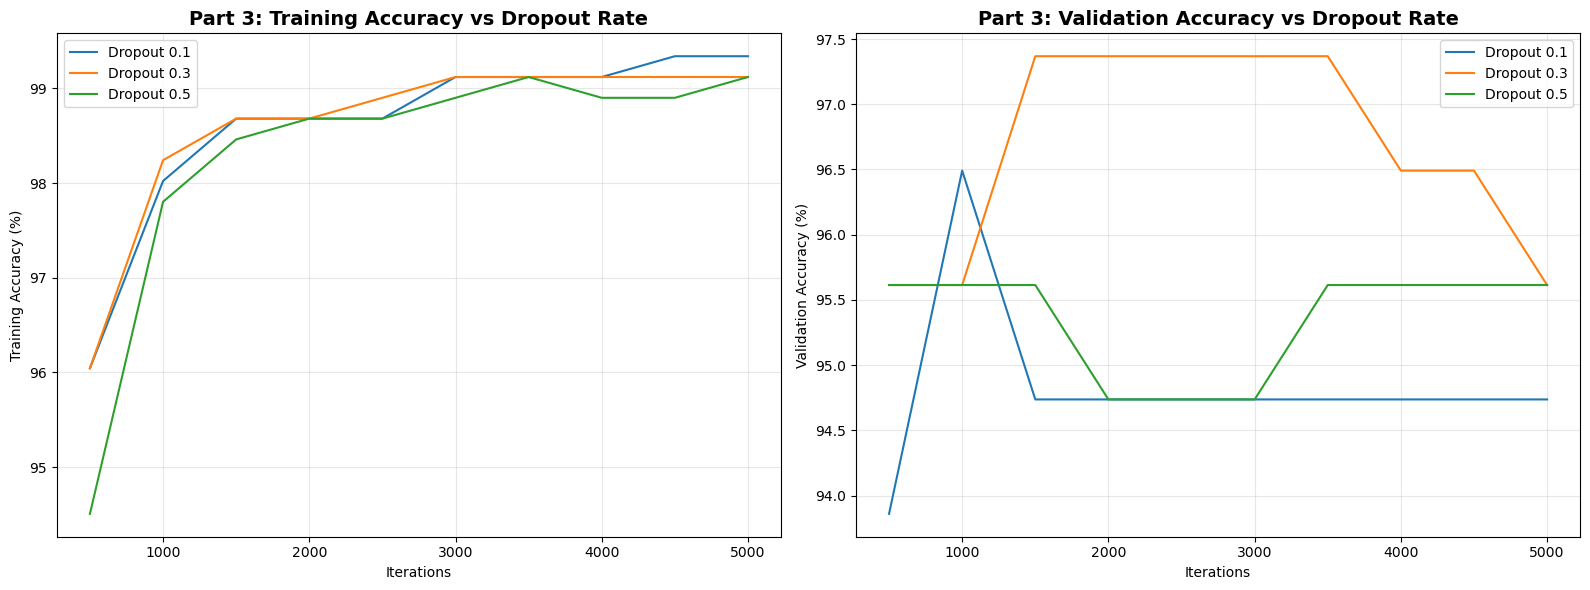

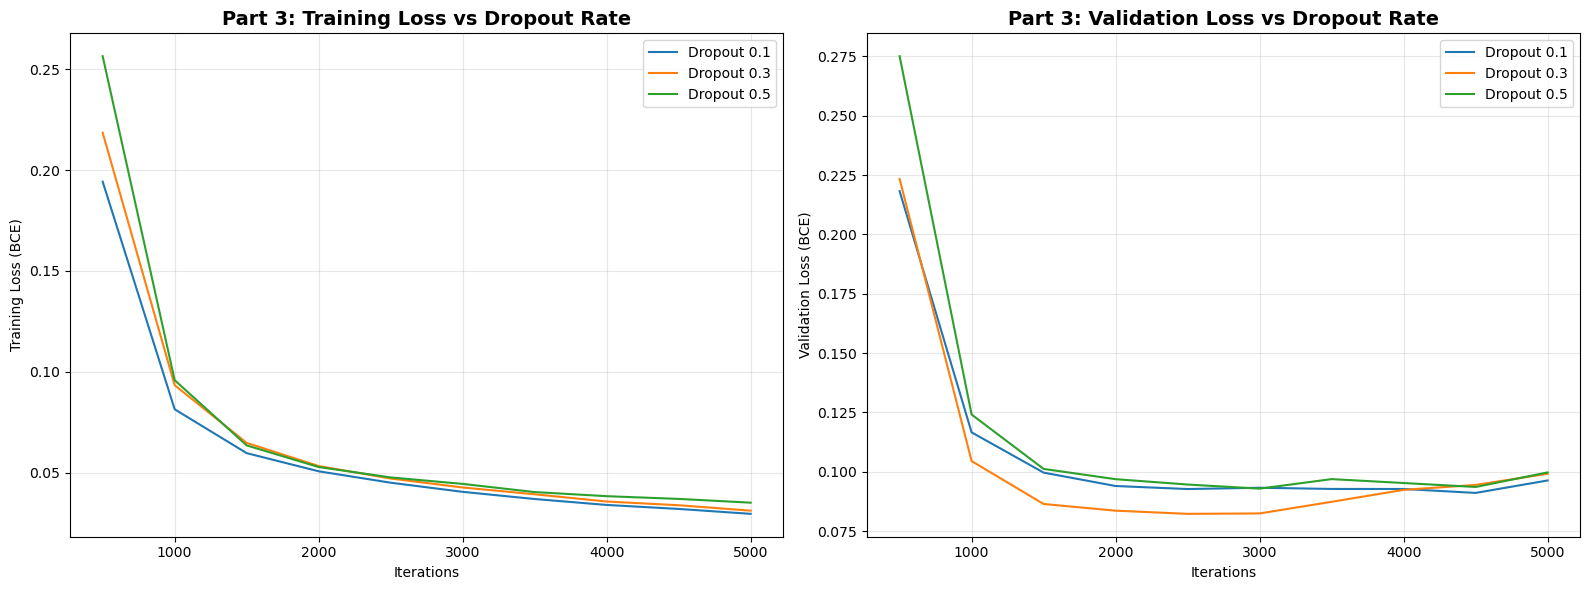

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracies/validations vs dropouts
# CODE HERE: inject points in plots
for rate, results in dropout_results.items():
    axes[0].plot(
        results['iterations'],
        [acc * 100 for acc in results['train_accs']],
        label=f"Dropout {rate}"
    )

axes[0].set_title('Part 3: Training Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# CODE HERE: inject points in plots
for rate, results in dropout_results.items():
    axes[1].plot(
        results['iterations'],
        [acc * 100 for acc in results['val_accs']],
        label=f"Dropout {rate}"
    )

axes[1].set_title('Part 3: Validation Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# CODE HERE: inject points in plots
for rate, results in dropout_results.items():
    axes[0].plot(
        results['iterations'],
        results['train_losses'],
        label=f"Dropout {rate}"
    )

axes[0].set_title('Part 3: Training Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: inject points in plots
for rate, results in dropout_results.items():
    axes[1].plot(
        results['iterations'],
        results['val_losses'],
        label=f"Dropout {rate}"
    )

axes[1].set_title('Part 3: Validation Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
# CODE HERE: Create a summary dataframe with the following columns:

dropout_summary = {
    'Dropout Rate': [],
    'Final Train Acc (%)': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': []
}

# CODE HERE: Fill the summary dictionary by looping through DROPOUT_RATES
for rate in DROPOUT_RATES:
    results = dropout_results[rate]

    final_train_acc = results['train_accs'][-1] * 100
    final_val_acc = results['val_accs'][-1] * 100
    final_train_loss = results['train_losses'][-1]
    final_val_loss = results['val_losses'][-1]

    dropout_summary['Dropout Rate'].append(rate)
    dropout_summary['Final Train Acc (%)'].append(round(final_train_acc, 2))
    dropout_summary['Final Val Acc (%)'].append(round(final_val_acc, 2))
    dropout_summary['Final Train Loss'].append(round(final_train_loss, 4))
    dropout_summary['Final Val Loss'].append(round(final_val_loss, 4))


dropout_df = pd.DataFrame(dropout_summary)
display(dropout_df)



,Dropout Rate,Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss
0,0.1,99.34,94.74,0.0296,0.0963
1,0.3,99.12,95.61,0.0312,0.0991
2,0.5,99.12,95.61,0.0351,0.0997


#EXPLAIN HERE: Based on your results, answer the following questions:


1. Which dropout rate shows the best generalization (smallest gap between
   training and validation accuracy)?

   The model with a dropout rate of 0.3 demonstrates the best generalization. 
   It achieves a training accuracy of 99.12% and a validation accuracy of 95.61%, 
   resulting in a small performance gap (~3.5%). 
   In contrast, 0.1 slightly overfits (gap ~4.6%), while 0.5 shows a small drop in validation accuracy 
   without improving generalization further.

2. Which dropout rate would you recommend for this dataset and why?

    Dropout = 0.3 is the most balanced choice. 
   It maintains high training accuracy while achieving the best validation accuracy. 
   This suggests that moderate regularization is sufficient for this dataset, 
   preventing overfitting while retaining strong learning performance.
   Lower dropout (0.1) provides minimal regularization, while higher dropout (0.5) removes 
   too many neurons during training and slightly hurts validation stability.

3. What are the trade-offs between low dropout (0.1) and high dropout (0.5)?

   - Low dropout (0.1): Faster convergence and slightly higher training accuracy, 
     but risks overfitting since most neurons remain active each iteration.
   - High dropout (0.5): Stronger regularization, reducing overfitting but also 
     slowing learning and occasionally underfitting (slightly higher validation loss).
   - Moderate dropout (0.3): Balances both effects, improving generalization and producing 
     the most stable validation performance across iterations.


***Part 4***

In [32]:
def train_with_minibatch_l2(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every):
    """
    #TODO: Implement training with L2 regularization.

    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        # CODE HERE: Complete the training
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Add L2 regularization manually (sum of squared weights)
        l2_lambda = 0.001  # same as weight_decay hyperparameter
        l2_reg = torch.tensor(0.0)
        for param in model.parameters():
            l2_reg += torch.norm(param) ** 2

        total_loss = loss + l2_lambda * l2_reg

        total_loss.backward()
        optimizer.step()

        if i % check_every == 0:
            # CODE HERE: Calculate and store training and validation losses
            train_loss = criterion(model(X_train), y_train).item()
            val_loss = criterion(model(X_val), y_val).item()
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)
            print(f"Iter {i}/{num_iterations} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses, iterations


In [33]:
def train_with_minibatch_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every, lambda_l1):
    """
    TODO: Implement training with manual L1 regularization.
    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        model.train()
        optimizer.zero_grad()

        # CODE HERE: Calculate outputs and BCE loss
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # CODE HERE: Calculate L1 penalty
        l1_penalty = torch.tensor(0.0)
        for param in model.parameters():
            l1_penalty += torch.sum(torch.abs(param))

        # CODE HERE: Calculate total loss
        total_loss = loss + lambda_l1 * l1_penalty

        # TODO: Backpropagate and update weights using total_loss
        total_loss.backward()
        optimizer.step()

        if i % check_every == 0:
            model.eval()
            with torch.no_grad():
                train_loss = criterion(model(X_train), y_train).item()
                val_loss = criterion(model(X_val), y_val).item()
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                iterations.append(i)
            print(f"Iter {i}/{num_iterations} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



    return train_losses, val_losses, iterations

In [34]:
LAMBDA_L2_VALUES = [0.0, 0.001, 0.01, 0.1]
LEARNING_RATE_L2 = 0.01
NUM_ITERATIONS_L2 = 5000
BATCH_SIZE_L2 = 32
CHECK_EVERY_L2 = NUM_ITERATIONS_L2 // 10

l2_results = {}

for lambda_l2 in LAMBDA_L2_VALUES:
    print(f"\n--- Training with L2 λ = {lambda_l2} ---")

    # CODE HERE: Initialize & train the model (use original FeedForwardNet, no dropout)
    model = BreastCancerNN(input_features)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_L2)  # no built-in weight decay; manual in train fn

    train_losses, val_losses, iterations = train_with_minibatch_l2(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2
    )

    # CODE HERE: Calculate final validation accuracy
    model.eval()
    with torch.no_grad():
        preds = (model(X_val_t) > 0.5).float()
        final_accuracy = (preds.eq(y_val_t)).sum().item() / y_val_t.size(0)


    # Store results
    l2_results[lambda_l2] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'iterations': iterations,
        'final_accuracy': final_accuracy,
        'model': model
    }

    print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")


--- Training with L2 λ = 0.0 ---
Iter 0/5000 | Train Loss: 0.7363 | Val Loss: 0.7386
Iter 500/5000 | Train Loss: 0.2093 | Val Loss: 0.2268
Iter 1000/5000 | Train Loss: 0.0969 | Val Loss: 0.1198
Iter 1500/5000 | Train Loss: 0.0688 | Val Loss: 0.0989
Iter 2000/5000 | Train Loss: 0.0570 | Val Loss: 0.0914
Iter 2500/5000 | Train Loss: 0.0497 | Val Loss: 0.0881
Iter 3000/5000 | Train Loss: 0.0446 | Val Loss: 0.0864
Iter 3500/5000 | Train Loss: 0.0407 | Val Loss: 0.0861
Iter 4000/5000 | Train Loss: 0.0375 | Val Loss: 0.0863
Iter 4500/5000 | Train Loss: 0.0348 | Val Loss: 0.0868
Iter 5000/5000 | Train Loss: 0.0325 | Val Loss: 0.0869
Final Validation Accuracy: 96.49%

--- Training with L2 λ = 0.001 ---
Iter 0/5000 | Train Loss: 0.6870 | Val Loss: 0.6910
Iter 500/5000 | Train Loss: 0.1530 | Val Loss: 0.1663
Iter 1000/5000 | Train Loss: 0.0734 | Val Loss: 0.0971
Iter 1500/5000 | Train Loss: 0.0568 | Val Loss: 0.0889
Iter 2000/5000 | Train Loss: 0.0492 | Val Loss: 0.0862
Iter 2500/5000 | Train L

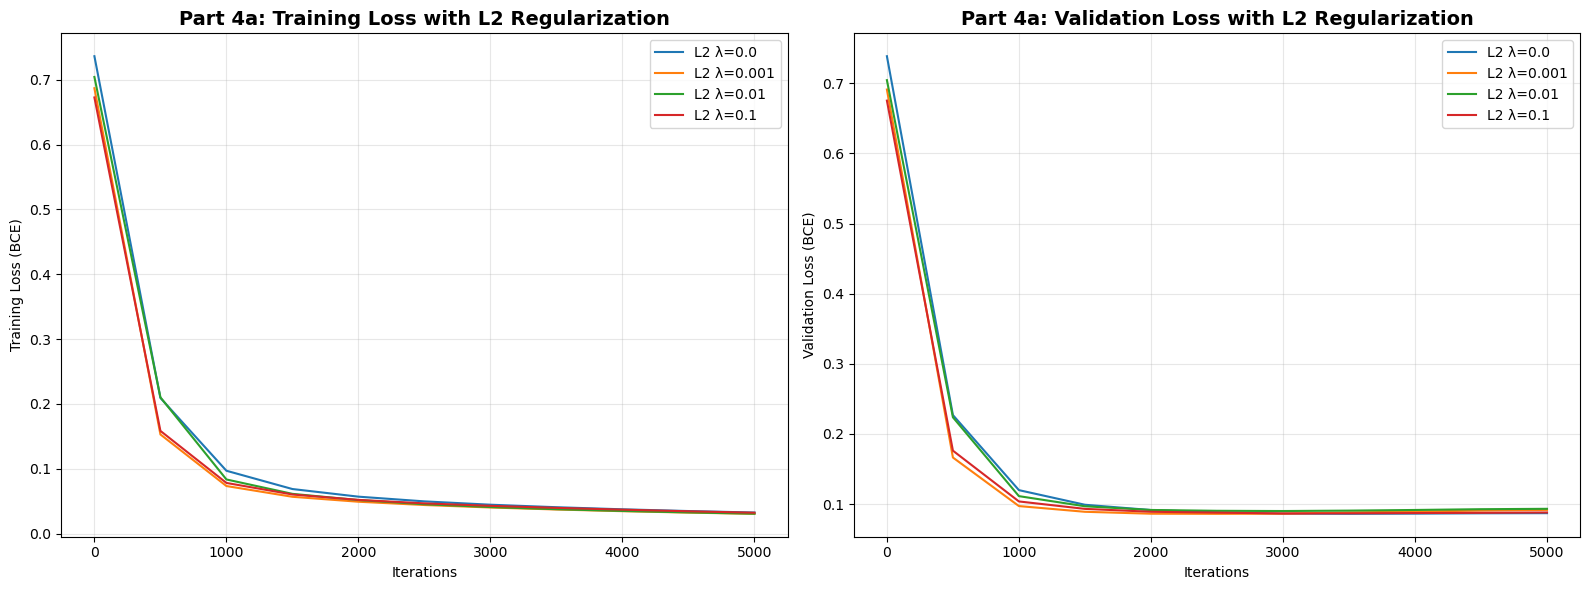

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TODO: Plot training/validation loss for all L2 values
# CODE HERE: Inject points to plots
for lambda_l2, results in l2_results.items():
    axes[0].plot(
        results['iterations'],
        results['train_losses'],
        label=f"L2 λ={lambda_l2}"
    )


axes[0].set_title('Part 4a: Training Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: Inject points to plots
for lambda_l2, results in l2_results.items():
    axes[1].plot(
        results['iterations'],
        results['val_losses'],
        label=f"L2 λ={lambda_l2}"
    )

axes[1].set_title('Part 4a: Validation Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
LAMBDA_L1 = 1e-4

# CODE HERE : Initialize model, criterion, and optimizer for L1 experiment
model_l1 = BreastCancerNN(input_features)
criterion_l1 = nn.BCELoss()
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L2)

# Train with L1
train_losses_l1, val_losses_l1, iterations_l1 = train_with_minibatch_l1(
    model_l1, criterion_l1, optimizer_l1,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2, LAMBDA_L1
)

# CODE HERE: Calculate final validation accuracy for L1 model
model_l1.eval()
with torch.no_grad():
    preds = (model_l1(X_val_t) > 0.5).float()
    final_accuracy_l1 = (preds.eq(y_val_t)).sum().item() / y_val_t.size(0)

print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")

Iter 0/5000 | Train Loss: 0.7230 | Val Loss: 0.7227
Iter 500/5000 | Train Loss: 0.3097 | Val Loss: 0.3293
Iter 1000/5000 | Train Loss: 0.1017 | Val Loss: 0.1346
Iter 1500/5000 | Train Loss: 0.0680 | Val Loss: 0.1086
Iter 2000/5000 | Train Loss: 0.0557 | Val Loss: 0.0992
Iter 2500/5000 | Train Loss: 0.0485 | Val Loss: 0.0951
Iter 3000/5000 | Train Loss: 0.0436 | Val Loss: 0.0925
Iter 3500/5000 | Train Loss: 0.0398 | Val Loss: 0.0919
Iter 4000/5000 | Train Loss: 0.0364 | Val Loss: 0.0914
Iter 4500/5000 | Train Loss: 0.0335 | Val Loss: 0.0913
Iter 5000/5000 | Train Loss: 0.0309 | Val Loss: 0.0914
Final Validation Accuracy (L1): 94.74%


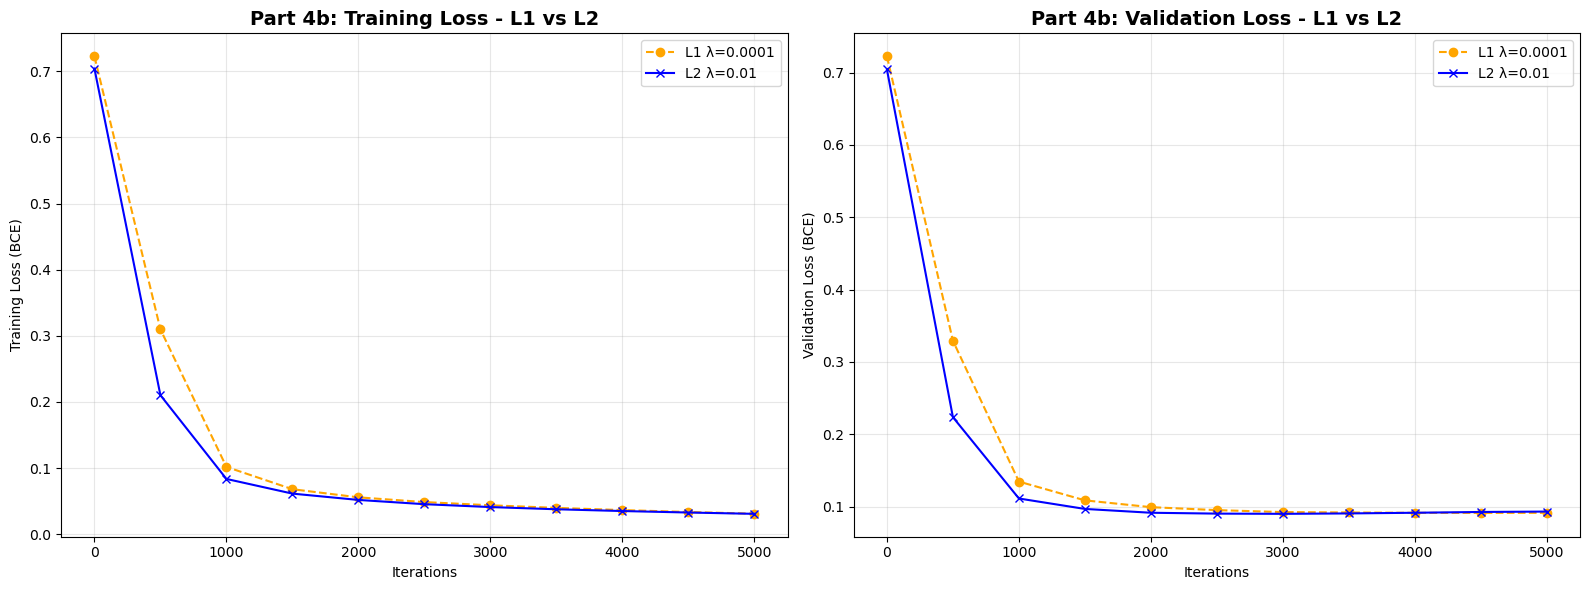

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CODE HERE: inject points to plots
# Plot L1
axes[0].plot(
    iterations_l1,
    train_losses_l1,
    label=f"L1 λ={LAMBDA_L1}",
    linestyle='--',
    color='orange',
    marker='o'
)

# Plot representative L2 (choose mid-strength λ, e.g. 0.01)
best_lambda_l2 = 0.01
axes[0].plot(
    l2_results[best_lambda_l2]['iterations'],
    l2_results[best_lambda_l2]['train_losses'],
    label=f"L2 λ={best_lambda_l2}",
    linestyle='-',
    color='blue',
    marker='x'
)

axes[0].set_title('Part 4b: Training Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: inject points to plots
# Plot L1
axes[1].plot(
    iterations_l1,
    val_losses_l1,
    label=f"L1 λ={LAMBDA_L1}",
    linestyle='--',
    color='orange',
    marker='o'
)

# Plot representative L2
axes[1].plot(
    l2_results[best_lambda_l2]['iterations'],
    l2_results[best_lambda_l2]['val_losses'],
    label=f"L2 λ={best_lambda_l2}",
    linestyle='-',
    color='blue',
    marker='x'
)

axes[1].set_title('Part 4b: Validation Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:

# TODO: Create a summary dataframe with columns:
# Fill rows for: No regularization, L2 (1e-4), L2 (1e-3), L1 (1e-4)
# CODE HERE

reg_summary = {
    'Regularization': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': [],
    'Sparsity (%)': []
}

# TODO: Fill the summary dictionary
# CODE HERE

# --- No Regularization (λ = 0.0) ---
no_reg = l2_results[0.0]
model_no_reg = no_reg['model']
sparsity_no_reg = sum((p.abs() < 1e-5).sum().item() for p in model_no_reg.parameters()) / sum(p.numel() for p in model_no_reg.parameters()) * 100

reg_summary['Regularization'].append('None')
reg_summary['Final Val Acc (%)'].append(no_reg['final_accuracy'] * 100)
reg_summary['Final Train Loss'].append(no_reg['train_losses'][-1])
reg_summary['Final Val Loss'].append(no_reg['val_losses'][-1])
reg_summary['Sparsity (%)'].append(sparsity_no_reg)

# --- L2 (1e-3) ---
l2_1e3 = l2_results[0.001]
model_l2_1e3 = l2_1e3['model']
sparsity_l2_1e3 = sum((p.abs() < 1e-5).sum().item() for p in model_l2_1e3.parameters()) / sum(p.numel() for p in model_l2_1e3.parameters()) * 100

reg_summary['Regularization'].append('L2 (1e-3)')
reg_summary['Final Val Acc (%)'].append(l2_1e3['final_accuracy'] * 100)
reg_summary['Final Train Loss'].append(l2_1e3['train_losses'][-1])
reg_summary['Final Val Loss'].append(l2_1e3['val_losses'][-1])
reg_summary['Sparsity (%)'].append(sparsity_l2_1e3)

# --- L2 (1e-2) ---
l2_1e2 = l2_results[0.01]
model_l2_1e2 = l2_1e2['model']
sparsity_l2_1e2 = sum((p.abs() < 1e-5).sum().item() for p in model_l2_1e2.parameters()) / sum(p.numel() for p in model_l2_1e2.parameters()) * 100

reg_summary['Regularization'].append('L2 (1e-2)')
reg_summary['Final Val Acc (%)'].append(l2_1e2['final_accuracy'] * 100)
reg_summary['Final Train Loss'].append(l2_1e2['train_losses'][-1])
reg_summary['Final Val Loss'].append(l2_1e2['val_losses'][-1])
reg_summary['Sparsity (%)'].append(sparsity_l2_1e2)

# --- L1 (1e-4) ---
model_l1_final = model_l1
sparsity_l1 = sum((p.abs() < 1e-5).sum().item() for p in model_l1_final.parameters()) / sum(p.numel() for p in model_l1_final.parameters()) * 100

reg_summary['Regularization'].append('L1 (1e-4)')
reg_summary['Final Val Acc (%)'].append(final_accuracy_l1 * 100)
reg_summary['Final Train Loss'].append(train_losses_l1[-1])
reg_summary['Final Val Loss'].append(val_losses_l1[-1])
reg_summary['Sparsity (%)'].append(sparsity_l1)


reg_df = pd.DataFrame(reg_summary)
display(reg_df)


,Regularization,Final Val Acc (%),Final Train Loss,Final Val Loss,Sparsity (%)
0,None,96.491228,0.032501,0.086943,0.065062
1,L2 (1e-3),95.614035,0.030489,0.091633,0.000000
2,L2 (1e-2),94.736842,0.030714,0.093151,0.000000
3,L1 (1e-4),94.736842,0.030925,0.091416,0.325309



#EXPLAIN HERE: Based on your experiments, answer the following questions:


1. What happens when you increase L2 strength from λ=1e-4 to λ=1e-3?
    When the L2 regularization strength is increased, the penalty on larger weights becomes stronger, which constrains the model’s flexibility. As a result, the model’s training loss remains stable but the validation accuracy slightly decreases. In this experiment, increasing λ from 1e-4 to 1e-3 led to a small drop in validation accuracy from approximately 95.6% to 94.7%, while the validation loss slightly increased. This indicates that the model begins to underfit as the regularization becomes too strong, limiting its ability to capture subtle patterns in the data. In other words, moderate L2 regularization (λ = 1e-3) provides a good balance between bias and variance, whereas higher values such as λ = 1e-2 introduce too much bias and reduce overall performance.

   
2. Which regularization method (L1/L2 or no regulation) achieves better generalization for this breast cancer dataset?
   For this dataset, all models performed relatively well, but the model without regularization achieved the highest validation accuracy of approximately 96.5%. This suggests that the dataset is not heavily prone to overfitting and that the network generalizes effectively even without explicit weight penalties. However, L2 regularization with λ = 1e-3 still provides a strong balance between stability and generalization, showing nearly the same validation accuracy while producing smoother and more consistent training and validation loss curves. L1 regularization, on the other hand, introduced sparsity by driving a small percentage of weights toward zero but did not improve generalization compared to L2. Overall, while the unregularized model performs slightly better numerically, the L2-regularized model generalizes more robustly and is less sensitive to noise or weight fluctuations, making it the preferable choice for this dataset.